# **Default Setting**

* Python: 3.6.9
* ML Framework: tensorflow-gpu 2.4.0 / tensorflow-addons 0.12.0
* CPU: AMD Ryzen 5 5600X 6-Core Processor
* GPU: GeForce RTX 3070 (8G) (CUDA 11.1)
* RAM: 32G
* Platform: Linux Ubuntu 20.04 LTS (desktop)

Install below APIs using anaconda as belows.

```
conda create -n py36 python=3.6.9
conda acitvate py36
pip3 install tensorflow-gpu=2.4.0 tensorflow-addons=0.12.0
conda install pandas, matplotlib, pydot, jupyterlab, cudatoolkit
```

And now, you can run jupyter lab (or jupyter notebook).

```
jupyter lab
```

In [1]:
%env NOTEBOOKNAME try180
%env LOCAL_DATA_PATH data
%env CHECKPOINT_PATH ckpt
%env SUBMISSION_PATH submission

env: NOTEBOOKNAME=try180
env: LOCAL_DATA_PATH=data
env: CHECKPOINT_PATH=ckpt
env: SUBMISSION_PATH=submission


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import datetime
import glob
import os
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

tf.__version__: 2.4.0
tfa.__version__: 0.12.0


In [3]:
# If you wanna avoid below error, you need to run below codes when you start kernel.

# UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, 
# so try looking to see if a warning log message was printed above. [Op:Conv2D]

# Ref: https://blog.naver.com/vft1500/221793591386

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs.


In [4]:
# !python -V

In [5]:
# !cat /proc/cpuinfo

In [6]:
!nvidia-smi

Tue Jan 12 19:57:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0  On |                  N/A |
| 41%   40C    P2    35W / 220W |    666MiB /  7979MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# !df -h

In [8]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       3.0Gi        19Gi       516Mi       8.4Gi        27Gi
Swap:         2.0Gi          0B       2.0Gi


In [9]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

# **Define Arguments**

In [10]:
class HParams(object):
    def __init__(self):
        # Basic
        self.seed = 42
        self.test_size = 0.2
        self.epoch = 100
        self.lr = 3e-3
        
        # Dataframe
        self.feature_dict = {}
        self.num_test_csv = 81
        self.day_split = 1
        self.day = 48
        self.inp = 7
        self.tar = 2
        
        # Dataset Pipeline
        self.w_inp = self.inp * self.day
        self.w_tar = self.tar * self.day
        self.w_shift = self.day
        self.w_stride = 1
        self.w_dr = True
        
        self.shuffle_buffer_sz = 100_000
        
        self.auto = tf.data.experimental.AUTOTUNE
        
        self.global_batch_size = 128
        
        # model
        self.num_features = 8
        self.num_quantile = 9
        
        self.input_shape = [self.inp, self.day, self.num_features] # non-residual model
        self.input_dtype = tf.float32
        self.units = 64
        self.out_steps = self.tar
        self.dropout_rate = 0.4
        self.activation = tf.keras.activations.relu
        
        self.nrm_kernel_sz = (9, 1)
        self.nrm_dilation_rate = (2, 1)
        
        self.rm_kernel_sz = (3, 3)
        self.rm_dilation_rate = (1, 1)
        
        # Remove checkpoints.
        self.max_to_keep = 3
        
        
HPARAMS = HParams()

# **Load Datasets**

## **Define Preprocessing Funciton**

In [11]:
def preprocessing(
    df: pd.DataFrame, 
    is_training: bool = True
) -> pd.DataFrame:
    """Preprocess dataframes without any normalize."""
    
    # Timestamp to signals.
    time = 2 * np.int64(df["Hour"]) + (np.int64(df["Minute"]) // 30)
    df.insert(loc = 0, column = "Time", value = time)
    
    day_sin = np.sin(df["Time"] * (2 * np.pi / HPARAMS.day))
    day_cos = np.cos(df["Time"] * (2 * np.pi / HPARAMS.day))
        
    df.insert(loc = 0, column = "DAY_SIN", value = day_sin)
    df.insert(loc = 1, column = "DAY_COS", value = day_cos)
    
    df = df.drop(["Day", "Hour", "Minute", "Time"], axis = 1)
    
    for column in df.columns:
        if is_training:
            HPARAMS.feature_dict[f"{column}_MAX"] = np.float32(df[column].max())
            HPARAMS.feature_dict[f"{column}_MIN"] = np.float32(df[column].min())
        
        df[column] = (df[column] - HPARAMS.feature_dict[f"{column}_MIN"]) \
            / (HPARAMS.feature_dict[f"{column}_MAX"] - HPARAMS.feature_dict[f"{column}_MIN"])
    
    return df

## **Train & Validation Dataframes**

In [12]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))
df.head(n = 10)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0
5,0,2,30,0,0,1.5,69.29,-11,0.0
6,0,3,0,0,0,1.5,72.56,-11,0.0
7,0,3,30,0,0,1.4,72.55,-11,0.0
8,0,4,0,0,0,1.3,74.62,-11,0.0
9,0,4,30,0,0,1.3,74.61,-11,0.0


In [13]:
# Forces the length of train and test data to be a multiple of the day.
HPARAMS.split_len = int(df.shape[0] * (1. - HPARAMS.test_size))
HPARAMS.split_len = HPARAMS.split_len - (HPARAMS.split_len % HPARAMS.day)

tr_df = df[:HPARAMS.split_len]
vl_df = df[HPARAMS.split_len:]

HPARAMS.epsilon = np.float32(tr_df["TARGET"][tr_df["TARGET"] > 0].min() * 0.9)

tr_df = preprocessing(tr_df)
vl_df = preprocessing(vl_df, is_training = False)

print(f"tr_df.shape: {tr_df.shape}, columns: {','.join(tr_df.columns)}")
print(f"vl_df.shape: {vl_df.shape}, columns: {','.join(vl_df.columns)}")

tr_df.shape: (42048, 8), columns: DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
vl_df.shape: (10512, 8), columns: DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET


## **Test Dataframe**

In [14]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(HPARAMS.num_test_csv)]
ts_dfs = [preprocessing(pd.read_csv(ts_filename), is_training = False) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

print(f"ts_df.shape: {ts_df.shape}, columns: {','.join(ts_df.columns)}")

ts_df.shape: (27216, 8), columns: DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET


# **Make Dataset Pipelines**

The first batch is to bundle the tensors as input into units of a day. The operation below can guarantee that the number of sequences of tr_tensor and vl_tensor is a multiple of a day (i.e. 48), so `drop_remainder = True` is actually meaningless. However, it was added to specify the shape of the input data during the window division process (`.window(...)`)

```
args["SPLIT_LEN"] = int(df.shape[0] * (1. - args["TEST_SIZE"]))
args["SPLIT_LEN"] = args["SPLIT_LEN"] - np.mod(args["SPLIT_LEN"], args["DAY"]) # this process

tr_df = df[:args["SPLIT_LEN"]]
vl_df = df[args["SPLIT_LEN"]:]
```

It is recommended to cache the dataset after the map transformation except if this transformation makes the data too big to fit in memory. A trade-off can be achieved if your mapped function can be split in two parts: a time consuming one and a memory consuming part. In this case, you can chain your transformations like below:

```
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

If the cache is executed after partioning the window, the amount of data loaded in the memory increases by about 9 times (=`(W_INP + W_TAR) / W_STRIDE)`. Obviously, the mapping process comsumes a lot of time, but since we have to train a model like this 9 times, it would be desirable to load it into the cache mory before the window split.

Also `cache` produce exactly the same elements during each iteration through the dataset. If you wish to randomize the iteration order, make sure to call `shuffle` after calling `cache`.

Immediately after the window is splited, the mapping function `_split_window` is called after stacking with `GLOBAL_BATCH_SIZE`. This time, the vectorized mapping function is called once and applies to a batch of sample. While the function could takes more time to execute, the overhead appear only once, improving the overall time performance.
        
*References*
   * *https://www.tensorflow.org/guide/data_performance*
   * *https://www.tensorflow.org/api_docs/python/tf/data/Dataset*

In [15]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(HPARAMS.w_inp + HPARAMS.w_tar)


@tf.function
def _flat_fn_ts(x):
    return x.batch(HPARAMS.w_inp)


@tf.function
def _reshape_tr(features):
    return tf.reshape(features, (-1, HPARAMS.inp + HPARAMS.tar, HPARAMS.day, HPARAMS.num_features))


@tf.function
def _reshape_ts(features):
    return tf.reshape(features, (-1, HPARAMS.inp, HPARAMS.day, HPARAMS.num_features))


@tf.function
def _split_window_tr(features):
    """
        input:  (batch, 9, 48, 8)
        output: (batch, 7, 48, 8), (batch, 2, 48, 1)
    """
    inp, tar = tf.split(features, [HPARAMS.inp, HPARAMS.tar], axis = 1)
    _, tar = tf.split(tar, [-1, 1], axis = -1)
    
    return inp, tar

In [16]:
# Dataframe to tensor. (TARGET column located on axis = -1)
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

# Tensor to dataset.
tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).window(HPARAMS.w_inp + HPARAMS.w_tar, HPARAMS.w_shift, HPARAMS.w_stride, HPARAMS.w_dr).flat_map(_flat_fn_tr
                    ).cache(
                    ).shuffle(HPARAMS.shuffle_buffer_sz, reshuffle_each_iteration = True
                    ).batch(HPARAMS.global_batch_size
                    ).map(_reshape_tr, num_parallel_calls = HPARAMS.auto
                    ).map(_split_window_tr, num_parallel_calls = HPARAMS.auto
                    ).prefetch(HPARAMS.auto)
                                                
vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).window(HPARAMS.w_inp + HPARAMS.w_tar, HPARAMS.w_shift, HPARAMS.w_stride, HPARAMS.w_dr).flat_map(_flat_fn_tr
                    ).cache(
#                     ).shuffle(HPARAMS.shuffle_buffer_sz, reshuffle_each_iteration = True
                    ).batch(HPARAMS.global_batch_size
                    ).map(_reshape_tr, num_parallel_calls = HPARAMS.auto
                    ).map(_split_window_tr, num_parallel_calls = HPARAMS.auto
                    ).prefetch(HPARAMS.auto)

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(HPARAMS.w_inp, HPARAMS.w_inp, 1, HPARAMS.w_dr).flat_map(_flat_fn_ts
                    ).cache(
#                     ).shuffle(HPARAMS.shuffle_buffer_sz, reshuffle_each_iteration = True
                    ).batch(HPARAMS.num_test_csv # not HPARAMS.global_batch_size
                    ).map(_reshape_ts, num_parallel_calls = HPARAMS.auto
                    ).prefetch(HPARAMS.auto)

# Print the shapes.
print("tr_dataset:")
print(f"\tinp: {tr_dataset.element_spec[0]}")
print(f"\ttar: {tr_dataset.element_spec[1]}")

print("vl_dataset:")
print(f"\tinp: {vl_dataset.element_spec[0]}")
print(f"\ttar: {vl_dataset.element_spec[1]}")

print("ts_dataset:")
print(f"\tinp: {ts_dataset.element_spec}")

tr_dataset:
	inp: TensorSpec(shape=(None, 7, 48, 8), dtype=tf.float32, name=None)
	tar: TensorSpec(shape=(None, 2, 48, 1), dtype=tf.float32, name=None)
vl_dataset:
	inp: TensorSpec(shape=(None, 7, 48, 8), dtype=tf.float32, name=None)
	tar: TensorSpec(shape=(None, 2, 48, 1), dtype=tf.float32, name=None)
ts_dataset:
	inp: TensorSpec(shape=(None, 7, 48, 8), dtype=tf.float32, name=None)


## **Take Samples**

In [17]:
# for element in tr_dataset.take(1):
#     foo, bar = element
#     print(foo.shape, bar.shape)

In [18]:
# for element in vl_dataset.take(1):
#     foo, (bar, qux) = element
#     print(foo.shape, bar.shape, qux.shape)

In [19]:
# for element in ts_dataset.take(1):
#     foo = element
#     print(foo.shape)

# **Define Loss Function**

Dacon defines the loss as shown below.

$$ L_\tau = maximum(\zeta\tau, \zeta(\tau-1)) $$

However, [the pinball loss of tensorflow-addons](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss) is implemented as follows.

$$ L_\tau = \begin{cases} \zeta\tau & \text{ if } \zeta \geq 0 \\ -\zeta(1-\tau)=\zeta(\tau-1) & \text{ if } \zeta < 0 \end{cases}$$

The description of the symbols used in is as follows.

* $\zeta$ : y_true - y_pred
* $\tau$ : Quantile values in \[0.1, 0.2, ..., 0.9\]
* $L_\tau$ : Pinball loss function with $\tau$

The two formulas seem intuitively different, but if you actually divide the interval, you can see that they are the same. However, in experience, it seems to force an underforecast when the evaluation expression of dacon is $\tau=0.1, 0.2$. In fact, for $\tau=0.1, 0.2$, the prediction (blue lines) in the target models mostly overlaps the label (yellow lines) or lies below the graph.

# **Create Network**

## **Basic AR-ConvLSTM1D Model**

In [39]:
class AR_ConvLSTM1D(tf.keras.Model):
    def __init__(
        self, 
        model_name: str,
        units: int,
        kernel_sz: tuple,
        dilation_rate: tuple,
        out_steps: int = HPARAMS.out_steps,
        dropout_rate: float = HPARAMS.dropout_rate,
        day: int = HPARAMS.day,
        use_bn: bool = False,
        activation: tf.keras.activations = HPARAMS.activation,
    ):
        super(AR_ConvLSTM1D, self).__init__(name = model_name)
        
        self.units = units        
        self.kernel_sz = kernel_sz
        self.dilation_rate = dilation_rate
        
        self.out_steps = out_steps
        self.dropout_rate = dropout_rate
        self.day = day
        self.use_bn = use_bn
        self.activation = activation
        
        if self.use_bn:
            self.stem = tf.keras.layers.TimeDistributed(tf.keras.Sequential([
                tf.keras.layers.Conv2D(
                    self.units, self.kernel_sz, dilation_rate = self.dilation_rate, 
                    padding = "same", activation = self.activation),
                tf.keras.layers.BatchNormalization()]))
        else:
            self.stem = tf.keras.layers.TimeDistributed(tf.keras.Sequential([
                tf.keras.layers.Conv2D(
                    self.units, self.kernel_sz, dilation_rate = self.dilation_rate, 
                    padding = "same", activation = self.activation)])) # no bn

        self.convlstm = tf.keras.layers.ConvLSTM2D(
            self.units, self.kernel_sz, dilation_rate = self.dilation_rate, 
            padding = "same", dropout = self.dropout_rate, return_state = True)
        self.expand_timestamp_dim = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))
        self.expand_channel_dim = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1))
        
        
    @tf.function
    def warmup(
        self, 
        inputs,
    ):
        """
             inputs: (batch, 7, 48, 1, units)
            outputs: (batch, 48, 1, units)
        """
        x, *state = self.convlstm(inputs)
        return x, state
    
    
    @tf.function
    def call(
        self, 
        inputs, 
        training = None,
    ):
        """
             inputs: (batch, 7, 48, num_features)
            outputs: (batch, 2, 48, num_features, units)
        """
        outputs = tf.TensorArray(tf.float32, size = self.out_steps) #, dynamic_size = False)
        
        # Stem.
        x = self.expand_channel_dim(inputs)
        x = self.stem(x)
        
        # Warm up.
        x, state = self.warmup(x)
        outputs = outputs.write(0, x)
        
        # Autoregressive loops.
        for n in tf.range(1, self.out_steps):
            x = self.expand_timestamp_dim(x)
            x, *state = self.convlstm(x, initial_state = state, training = training)
            outputs = outputs.write(n, x)
        
        return tf.transpose(outputs.stack(), [1, 0, 2, 3, 4])        

## **Non-Residual Model**

In [63]:
def Non_Residual_Model(
    model_name: str,
    units: int = HPARAMS.units,
    kernel_sz: tuple = HPARAMS.nrm_kernel_sz,
    dilation_rate: tuple = HPARAMS.nrm_dilation_rate,
    out_steps: int = HPARAMS.out_steps,
    dropout_rate: float = HPARAMS.dropout_rate,
    day: int = HPARAMS.day,
    activation = HPARAMS.activation,
) -> tf.keras.Model:
    """Create an emsembled ar-convlstm model by feature-wise."""
    
    model_input = tf.keras.layers.Input(shape = HPARAMS.input_shape, dtype = HPARAMS.input_dtype)
    
#     print(model_input.shape[-1])
#     xs = tf.split(model_input, model_input.shape[-1], axis = -1)[2, 3, 7]
    
    
    xs = tf.keras.layers.Lambda(lambda x: tf.split(x, x.shape[-1], axis = -1), name = "feature-wised_split")(model_input)
    xs = [xs[2], xs[3], xs[7]]

    submodels = [
        AR_ConvLSTM1D(f"{model_name}_DNI", units, kernel_sz, dilation_rate),
        AR_ConvLSTM1D(f"{model_name}_DHI", units, kernel_sz, dilation_rate),
        AR_ConvLSTM1D(f"{model_name}_TARGET", 2 * units, kernel_sz, dilation_rate)]
    
    # Prediction
    xs = [submodel(x) for submodel, x in zip(submodels, xs)]
    
    # Concat and re-prediction.
    x = tf.keras.layers.Concatenate(axis = -1)(xs)
    x = tf.keras.layers.Reshape((out_steps, day, -1))(x)
    
    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv1D(x.shape[-1], kernel_sz[0], padding = "same", activation = activation))(x)
    x = tf.keras.layers.SpatialDropout2D(dropout_rate)(x)
    
    model_output = tf.keras.layers.Dense(1, activation = activation)(x)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)    

In [68]:
# tmp = Non_Residual_Model("tmp")
# tmp.summary()

In [69]:
# tf.keras.utils.plot_model(tmp, show_layer_names = True, show_shapes = False)

In [70]:
# tf.keras.utils.plot_model(tmp, show_shapes = True)

In [71]:
# del tmp

## **Residual Model**

In [84]:
def Residual_Model(
    model_name: str,
    kernel_sz: tuple = HPARAMS.rm_kernel_sz,
    dilation_rate: tuple = HPARAMS.rm_dilation_rate,
    units: int = HPARAMS.units,
    out_steps: int = HPARAMS.out_steps,
    dropout_rate: float = HPARAMS.dropout_rate,
    day: int = HPARAMS.day,
    activation = HPARAMS.activation,
) -> tf.keras.Model:
    """Create an emsembled ar-convlstm model by feature-wise."""
   
    predict_delta = tf.keras.layers.TimeDistributed(tf.keras.Sequential([
        tf.keras.layers.SpatialDropout1D(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(HPARAMS.num_features * units, activation = activation),
        tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.Zeros())], name = "predict_delta"))
    add = tf.keras.layers.Add(name = "residual_add")
    outputs = []
    
    # Entry Flow.
    model_input = tf.keras.layers.Input(shape = HPARAMS.input_shape, dtype = HPARAMS.input_dtype)
    
    # Middle Flow.
    x = AR_ConvLSTM1D(f"{model_name}_convlstm", units, kernel_sz, dilation_rate)(model_input)
    xs = tf.keras.layers.Lambda(lambda x: tf.unstack(x, axis = 1), name = "unstack")(x)
    
    residual_seed = tf.keras.layers.Lambda(lambda x: x[:, -1, :, -1:], name = "residual_seed")(model_input)
    outputs.append(add([residual_seed, predict_delta(xs[0])]))
    
    # Cumulative sum.
    for i in range(1, out_steps):
        outputs.append(add([outputs[-1], predict_delta(xs[i])]))

    # Exit flow.
    model_output = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis = 1), name = "stack_output")(outputs)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [42]:
# tmp = Residual_Model("tmp")
# tmp.summary()

In [43]:
# tf.keras.utils.plot_model(tmp, show_layer_names = True, show_shapes = False)

In [44]:
# tf.keras.utils.plot_model(tmp, show_shapes = True)

In [45]:
# del tmp

# **Compile and Fit**

In [87]:
def scheduler(
    epoch, 
    lr
):
    # lr = 0.96 * lr for every 2 epochs
    if not epoch:
        return lr
    elif not (epoch % 2):
        return 0.96 * lr
    else:
        return lr


def get_callbacks(
    model_name: str,
) -> list:
    """Get some callbacks."""

    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    # Checkpoint callback.
    ckpt_path = os.path.join(
        os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], 
        model_name, "cp-{epoch:03d}-{val_loss:.6f}.ckpt")
    ckpt_dir = os.path.dirname(ckpt_path)
    os.makedirs(ckpt_dir, exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_loss", save_weights_only = True, save_best_only = True)
    
    # TensorBoard callback.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], datetime.datetime.now().strftime(f"{model_name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1, update_freq = "batch")
    
    return [lr_callback, cp_callback, tb_callback]
    

def compile_and_fit(
    model: tf.keras.Model, 
    tau: float, 
    tr_dataset: tf.data.Dataset, 
    vl_dataset: tf.data.Dataset, 
    epochs: int,
    lr: float,
    verbose: int = 0, 
) -> dict:
    """Compile and fit the model."""
        
    model.compile(
        loss = tfa.losses.PinballLoss(tau = tau),
#         optimizer = adabelief_tf.AdaBeliefOptimizer(learning_rate = lr))
        optimizer = tfa.optimizers.RectifiedAdam(lr, warmup_proportion = 0, weight_decay = 5e-4))
#         optimizer = tf.keras.optimizers.Adam(lr))
    
    print(f"Model {model.name}...")

    history = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = epochs,
        verbose = verbose,
        callbacks = get_callbacks(model.name))

    return history

In [89]:
%%time

# histories = {}

for tau in np.arange(0.1, 1, 0.1):
    # Adaptive modeling.
    if tau in np.arange(0.1, 0.5, 0.1):
        model = Non_Residual_Model(model_name = f"P{tau:.1f}")
        print("Non-Residual ", end = "")
    else:
        model = Residual_Model(model_name = f"P{tau:.1f}")
        print("Residual ", end = "")
    
    _ = compile_and_fit(
        model, 
        tau, 
        tr_dataset, 
        vl_dataset, 
        HPARAMS.epoch,
        HPARAMS.lr,
        verbose = 0)
    
#     histories[model.name] = history
    del model # for save memories

Non-Residual Model P0.2...
CPU times: user 3min 27s, sys: 15.5 s, total: 3min 43s
Wall time: 2min 40s


In [ ]:
# %load_ext tensorboard
%tensorboard --logdir logs/fit --host jupyter-server --port 6006

## **Make Clean Checkpoints**

In [92]:
%%time

ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "*")))

num_rm_files = 0
rm_files_sz = 0 # bytes

for f in ckpt_folders:
    # 7 files must be located in ckpt_folders. (latest 3 ckpt, it's index and checkpoint file)
    assert len(os.listdir(f)) >= (1 + HPARAMS.max_to_keep * 2), f"Checkpoints in {f} is less then 3 (max_to_keep)."
    
    rm_files = [os.path.join(f, i) for i in sorted(os.listdir(f))[1:-2*HPARAMS.max_to_keep]] # [1:-6]
    num_rm_files += len(rm_files)
    rm_files_sz += sum([os.path.getsize(rm_file) for rm_file in rm_files])
    
    _ = [os.remove(rm_file) for rm_file in rm_files]
    
print(f"{num_rm_files} files removed.")
print(f"{rm_files_sz / 2**20:.2f}MB saved.")

364 files removed.
1847.41MB saved.
CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 19.9 ms


# **Visualize**

## **Plot Histories**

In [23]:
# def draw_histories(
#     histories: dict,
# ):
#     """Draw 9 histories in one plot."""
    
#     assert len(histories.keys()) == HPARAMS.num_quantile
    
#     plt.figure(figsize = (18, 14), facecolor = "white", dpi = 96)

#     for model_name, history in histories.items():
#         pos = int(model_name.split(".")[-1])
#         plt.subplot(3, 3, pos)
                
#         plt.plot(history.epoch, history.history["loss"], c = "tomato", ls = "-", label = "loss")
#         plt.plot(history.epoch, history.history["val_loss"], c = "navy", ls = "-", label = "val_loss")
    
#         plt.legend(loc = "upper left")
#         plt.title(model_name, fontsize = 20)
#         plt.xlabel("Epoch")
#         plt.ylabel("Pinball Loss")
    
#         plt.grid(True)
        
#     plt.tight_layout()
#     plt.show()

In [24]:
# draw_histories(histories)

## **Target Model Prediction**

In [95]:
def load_latest_models(
    ckpt_folders: list,
) -> list:
    """Load latest weights of target model from saved ckeckpoints."""   
    
    models = []
    val_losses = []
    
    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...", end = " ")
        
        model_name = latest.split(os.path.sep)[-2] # ckpt/[notebookname]/P0.1/...
        tau = model_name[1:]
        val_loss = np.float32(latest.split(os.path.sep)[-1].split("-")[2][:8])
        
        # Define a new adaptive model and load checkpoints.
        if re.match('0.[0-4]', tau):
            model = Non_Residual_Model(model_name = model_name)
            print("[Non-Residual Model]")
        else:
            model = Residual_Model(model_name = model_name)
            print("[Residual Model]")

        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()
        models.append(model)
        
        val_losses.append(val_loss)
        
    return models, val_losses


def draw_pred(
    inputs, 
    y_preds, 
    y_true, 
    save_fig = False,
):
    """Draw the predictions and labels."""
    
    plt.figure(figsize = (14, 4 * HPARAMS.num_quantile), facecolor = "white")
    
    for i, (y_pred, tau) in enumerate(zip(y_preds, np.arange(0.1, 1, 0.1))):
        plt.subplot(9, 1, i + 1)
        
        plt.plot(np.arange(len(inputs)), inputs, lw = 1.5, label = "Inputs")
        plt.plot(np.arange(len(inputs), len(inputs) + len(y_pred), 1), y_pred, marker = "o", lw = 1.5, label = "Predictions")
        plt.plot(np.arange(len(inputs), len(inputs) + len(y_true), 1), y_true, marker = "X", lw = 1.5, label = "Label")
    
        plt.title(f"Target Model T{tau:.1f}")
        plt.xlabel("Time [day]")
        plt.ylabel("Target")
        plt.ylim([-0.08, max(y_true) * 1.1])
        plt.legend()

        plt.xticks(
            np.arange(0, HPARAMS.w_inp + HPARAMS.w_tar + 1, HPARAMS.day), 
            [f"D+{i}" for i in np.arange(HPARAMS.inp + HPARAMS.tar + 1)])
        plt.grid(True)
        
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(os.path.join("pngs", f"{os.environ['NOTEBOOKNAME']}.png"), dpi = 96)
        
    plt.show()

Load latest checkpoints: ckpt/try180/P0.1/cp-028-0.014086.ckpt... [Non-Residual Model]
Load latest checkpoints: ckpt/try180/P0.2/cp-075-0.022835.ckpt... [Non-Residual Model]
Load latest checkpoints: ckpt/try180/P0.3/cp-044-0.027007.ckpt... [Non-Residual Model]
Load latest checkpoints: ckpt/try180/P0.4/cp-064-0.028207.ckpt... [Non-Residual Model]
Load latest checkpoints: ckpt/try180/P0.5/cp-042-0.026733.ckpt... [Residual Model]
Load latest checkpoints: ckpt/try180/P0.6/cp-049-0.023526.ckpt... [Residual Model]
Load latest checkpoints: ckpt/try180/P0.7/cp-073-0.018890.ckpt... [Residual Model]
Load latest checkpoints: ckpt/try180/P0.8/cp-096-0.013442.ckpt... [Residual Model]
Load latest checkpoints: ckpt/try180/P0.9/cp-069-0.007414.ckpt... [Residual Model]
Averaged Validation Loss: 2.0220


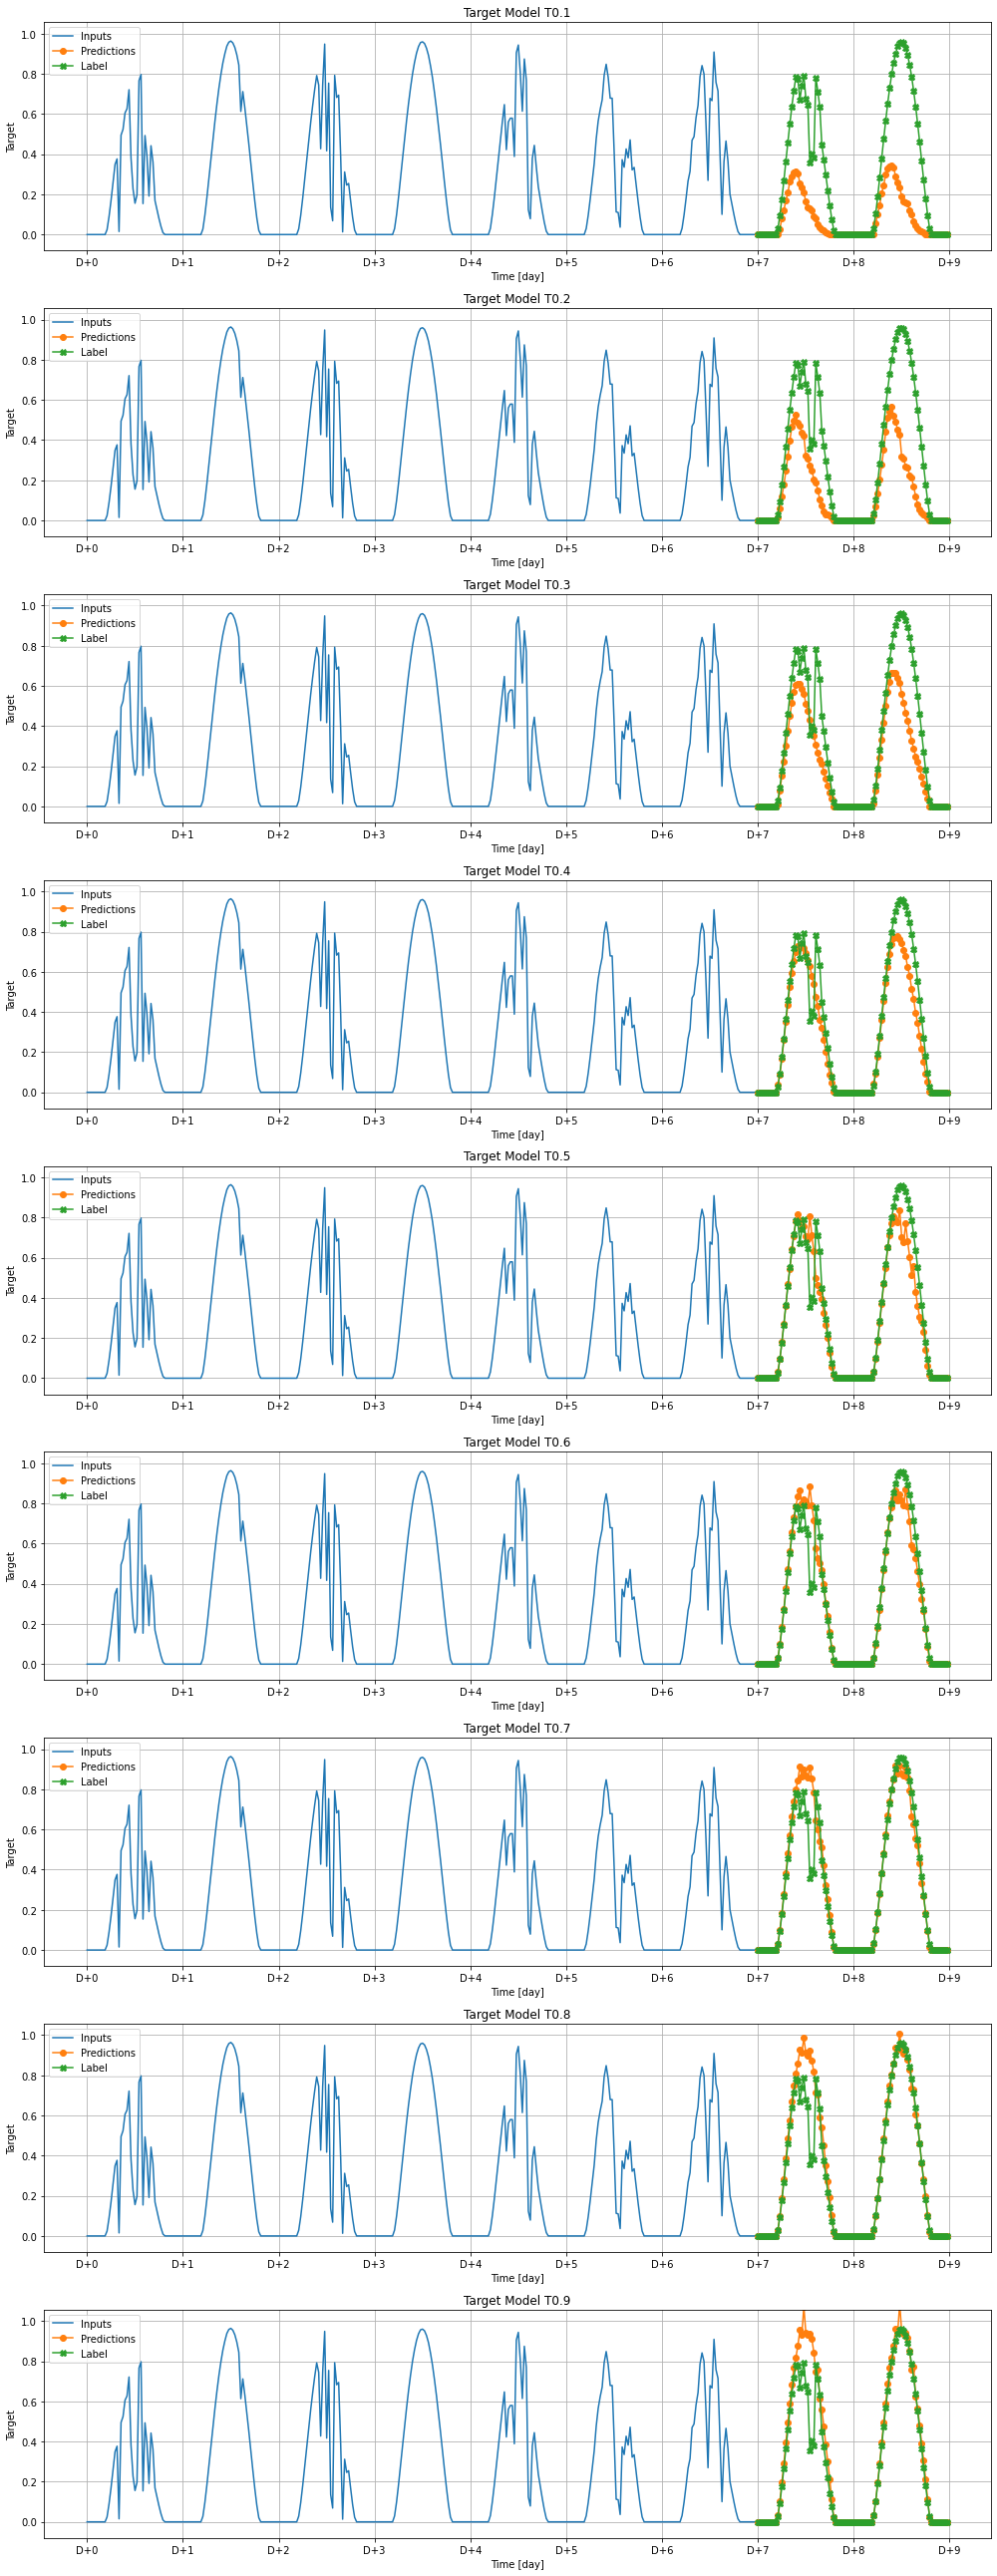

In [96]:
# Restore latest models from saved checkpoints.
ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
models, val_losses = load_latest_models(ckpt_folders)

avg = np.mean(val_losses) * (HPARAMS.feature_dict["TARGET_MAX"] - HPARAMS.feature_dict["TARGET_MIN"]) \
        + HPARAMS.feature_dict["TARGET_MIN"]
print(f"Averaged Validation Loss: {avg:.4f}")

# Now, unbatch the dataset to predict only one sequences (i.e. 7 days).
unbatched_vl_dataset = vl_dataset.unbatch().batch(1)

for t in unbatched_vl_dataset.take(1):
    x, y = t # inp, aux_tar, real_tar
    
    draw_pred(
        inputs = vl_tensor[:HPARAMS.w_inp, -1], # not x
        y_preds = [tf.reshape(model.predict(x), (-1, )).numpy() for model in models],
        y_true = tf.reshape(y, (-1, )))

# **Make Submissions**

In [97]:
%%time
# Restore latest models from saved checkpoints.
ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
models, _ = load_latest_models(ckpt_folders)

# Predict the test datasets.
preds = [np.array(tf.reshape(model.predict(ts_dataset), (-1, ))) for model in models]

Load latest checkpoints: ckpt/try180/P0.1/cp-028-0.014086.ckpt... [Non-Residual Model]
Load latest checkpoints: ckpt/try180/P0.2/cp-075-0.022835.ckpt... [Non-Residual Model]
Load latest checkpoints: ckpt/try180/P0.3/cp-044-0.027007.ckpt... [Non-Residual Model]
Load latest checkpoints: ckpt/try180/P0.4/cp-064-0.028207.ckpt... [Non-Residual Model]
Load latest checkpoints: ckpt/try180/P0.5/cp-042-0.026733.ckpt... [Residual Model]
Load latest checkpoints: ckpt/try180/P0.6/cp-049-0.023526.ckpt... [Residual Model]
Load latest checkpoints: ckpt/try180/P0.7/cp-073-0.018890.ckpt... [Residual Model]
Load latest checkpoints: ckpt/try180/P0.8/cp-096-0.013442.ckpt... [Residual Model]
Load latest checkpoints: ckpt/try180/P0.9/cp-069-0.007414.ckpt... [Residual Model]
CPU times: user 13.4 s, sys: 127 ms, total: 13.5 s
Wall time: 13.6 s


In [98]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
    foo = foo * (HPARAMS.feature_dict["TARGET_MAX"] - HPARAMS.feature_dict["TARGET_MIN"]) \
            + HPARAMS.feature_dict["TARGET_MIN"]
    foo = np.where(foo < HPARAMS.epsilon, 0, foo) # clip by value
    
    submission[column] = foo

In [100]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
submission.to_csv(os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))